In [3]:
import pickle

import em
from models import RBFInterpolatorModel, load_data


# Transformer 0.65um 


Octagonal transformer in TSMC 65 um. 1T + overlaped (balun)


In [4]:
#turn and freq independent @ 28GHz SRF > 38GHz
sub_spaces = [(1,1, "_balun"), (1,1, ""), (2,2, "_balun"), (1,2, ""), (2,1, "")]


def ranges(df_train, df_test):
    df_test = df_test[df_test.Dinp > 30]
    df_test = df_test[df_test.Wp > 5]
    df_test = df_test[df_test.Dinp < 170 ]

    return  df_train, df_test


model_table = {}
for subsp in sub_spaces:
    print(f"Subspace: {subsp}")
    for f in range(201):

        freq, x_train, y_train, x_test, y_test, srf_data = load_data("../data/transf_65nm/", f, srf=3, nt=subsp, n_samples=1000, filter=ranges)
        
        if 'balun' in subsp[2]:
            m = RBFInterpolatorModel(degree=4)
            m.fit(x_train[:,[0,1]], y_train)
            pred = m.predict(x_test[:,[0,1]])
        else:
            m = RBFInterpolatorModel(degree=5)
            m.fit(x_train, y_train)
            pred = m.predict(x_test)

        if (max_mean_error := max(em.mape_lq_diff(freq, pred, y_test)[0])) > 10 :
            print(f"{f} : {max_mean_error}")

        mdl = {
                'freq_index': f,
                'freq': freq[0],
                'nt': subsp,
                'RBFmodel': m
        }
        model_table[(subsp, f)] = mdl

    srf_m = RBFInterpolatorModel(degree=3)
    if 'balun' in subsp[2]:
        srf_m.fit(srf_data[0][:, [0,1]], srf_data[1][:, [0]])
    else:
        srf_m.fit(srf_data[0], srf_data[1])
        
    srf_mdl = {
            'srf_limit': 3,
            'nt': subsp,
            'RBFmodel': srf_m
    }
    model_table[(subsp, 'srf')] = srf_mdl


Subspace: (1, 1, '_balun')
55 : 10.964429688873103
78 : 13.206343426325956
84 : 42.684563189223866
129 : 13.075760168572279
176 : 15.01923682318573
Subspace: (1, 1, '')
98 : 11.67867499693928
105 : 21.24373686709652
123 : 17.82802944168282
129 : 52.325009572267625
132 : 43.255907422319616
133 : 35.672261028843465
135 : 22.94240097710461
138 : 19.29272654061858
140 : 49.77182192398043
144 : 24.759409996475192
145 : 65.67938841985946
151 : 11.797716856747023
157 : 122.77498057577942
163 : 111.42425662541932
164 : 13.238212511318304
165 : 11.120219462170393
166 : 10.346484904029753
169 : 39.035762695504864
170 : 10.912764402272272
171 : 15.351929188582512
173 : 14.460883948959092
174 : 32.838041464314095
175 : 24.941640426634617
180 : 140.35289348158267
190 : 11.075775316438094
192 : 26.437163247611323
193 : 14.18902618119559
194 : 20.762993825525008
200 : 13.088441019743568
Subspace: (2, 2, '_balun')
30 : 19.78845272139498
35 : 11.367063196663663
61 : 14.495764008853994
75 : 40.094008850

In [5]:
model_table['inputs'] = ['Dinp', 'Wp', 'Dins', 'Ws']
model_table['ouputs'] = em.COLUMNS_6P[1:]
model_table['device'] = 'transf'
model_table['model'] = 'transf'
model_table['ranges'] = {'dinp': (30, 190), 'wp': (4, 14), 'np': (1,1), 'dins': (30, 190), 'ws': (4, 14), 'ns': (1,1), 'freq': (0, 200)}
model_table['key'] = {'nt':sub_spaces, 'f':(0, 201)}

with open("../PASSIVES_RBF_TRANSF_BALUN_28G_SRF38_v1.model",'wb') as outfile:
    pickle.dump(model_table, outfile)  

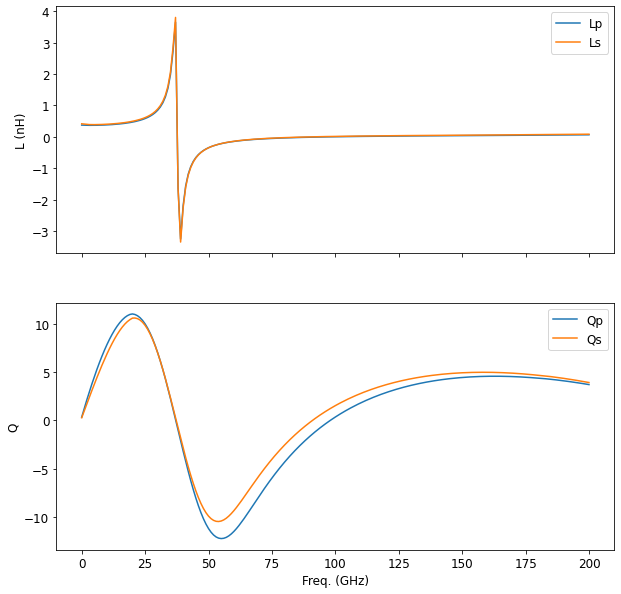

In [8]:
from models import PassivesModel

tranf_model = PassivesModel("../../em-model/PASSIVES_RBF_TRANSF_BALUN_28G_SRF38_v1.model")
resp, resp_arg = tranf_model.simulate(np=2, ns=2, dinp=45, wp=5, dins=45, ws=5) 
tranf_model.save(sri_fname="../test_out_in.sri", lq_fname= "../test_out_in.out")
tranf_model.plot()


###### Copyright (C) 2022 Instituto de Telecomunicações & IMSE CSIC